# **Pneumonia Detection Challenge - Project**

Context

Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation of  the  lungs.  In  this  challenge,  you’re  required  to  build  an  algorithm  to  detect  a  visual  signal  for  pneumonia  in  medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.


### Data Description

In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.


### **Milestone 1**

In [ ]:
!pip install opencv-python pydicom tensorflow tabulate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 58.4 MB/s eta 0:00:00


#### **Step 1: Import the data**

In [1]:
# Import required libraries

import os
import io
import gc
import cv2
import random
import pydicom
import warnings
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from glob import glob
from tqdm import tqdm
from tensorflow.keras import Input
from functools import lru_cache
from tabulate import tabulate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras import mixed_precision
from tensorflow.keras.regularizers import l2

# Ignoring warnings
warnings.filterwarnings("ignore")

# Configuration
class Config:
    IMG_SIZE = (224, 224)  # Optimized for EfficientNet
    BATCH_SIZE = 32
    NUM_CLASSES = 3
    EPOCHS = 10
    LEARNING_RATE = 1e-4
    VALIDATION_SPLIT = 0.2
    SEED = 42

    # Data augmentation parameters
    ROTATION_RANGE = 10
    WIDTH_SHIFT_RANGE = 0.1
    HEIGHT_SHIFT_RANGE = 0.1
    ZOOM_RANGE = 0.1

    # Model parameters
    DROPOUT_RATE = 0.3
    L2_REG = 1e-4

# Set seeds for reproducibility
tf.random.set_seed(Config.SEED)
np.random.seed(Config.SEED)

# Enable mixed precision for faster training
#policy = tf.keras.mixed_precision.Policy('mixed_float16')
#tf.keras.mixed_precision.set_global_policy(policy)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Define paths
#train_labels_path =  '/content/drive/My Drive/AIML/Capstone/stage_2_train_labels.csv'
#class_info_path = '/content/drive/My Drive/AIML/Capstone/stage_2_detailed_class_info.csv'
train_labels_path =  'stage_2_train_labels.csv'
class_info_path = 'stage_2_detailed_class_info.csv'


# Load CSV files
train_labels_df = pd.read_csv(train_labels_path)
class_info_df = pd.read_csv(class_info_path)

# Display first few rows of each DataFrame
print("Train Labels DataFrame (First 5 rows):")
print(train_labels_df.head())
print("\nClass Info DataFrame (First 5 rows):")
print(class_info_df.head())

# Basic stats about the datasets
print("\nTrain Labels DataFrame Info:")
print(f"Shape: {train_labels_df.shape}")
print(f"Columns: {train_labels_df.columns.tolist()}")

print("\nClass Info DataFrame Info:")
print(f"Shape: {class_info_df.shape}")
print(f"Columns: {class_info_df.columns.tolist()}")

# Check for missing values
print("\nMissing values in Train Labels DataFrame:")
print(train_labels_df.isnull().sum())
print("\nMissing values in Class Info DataFrame:")
print(class_info_df.isnull().sum())

# Count unique patients
unique_patients_labels = train_labels_df['patientId'].nunique()
unique_patients_class = class_info_df['patientId'].nunique()
print(f"\nNumber of unique patients in Train Labels: {unique_patients_labels}")
print(f"Number of unique patients in Class Info: {unique_patients_class}")

Train Labels DataFrame (First 5 rows):
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

Class Info DataFrame (First 5 rows):
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

Train Labels DataFrame Info:
Shape: (302

#### **Step 2: Map training images to its classes**


Class Distribution:
class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64


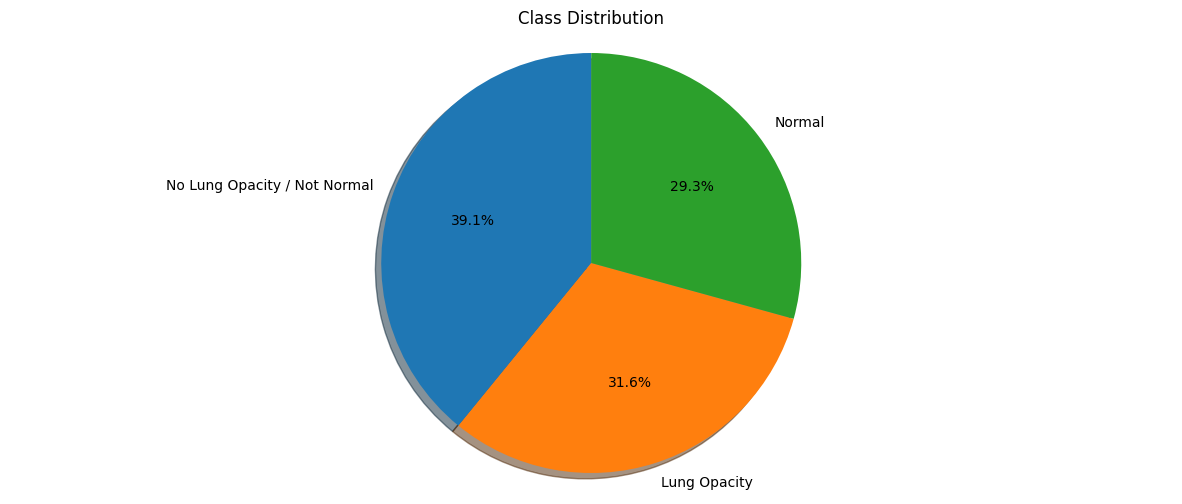

In [3]:
patient_class_df = class_info_df.copy()

# Count the number of instances for each class
class_counts = patient_class_df['class'].value_counts()
print("\nClass Distribution:")
print(class_counts)

# Create a pie chart for class distribution
plt.figure(figsize=(15, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

#### **Step 3: Map training images to its annotations**

In [4]:
# Create a mapping of patient IDs to their respective bounding boxes
patient_boxes = {}
for index, row in train_labels_df.iterrows():
    patient_id = row['patientId']
    target = row['Target']

    if target == 1:  # Only consider rows with Target=1 (has bounding box)
        if patient_id not in patient_boxes:
            patient_boxes[patient_id] = []

        # Add bounding box coordinates
        patient_boxes[patient_id].append({
            'x': row['x'],
            'y': row['y'],
            'width': row['width'],
            'height': row['height']
        })

# Create a mapping of patient IDs to their classes
patient_class_map = dict(zip(patient_class_df['patientId'], patient_class_df['class']))

# Create a combined dataframe for easier analysis
combined_df = train_labels_df.merge(class_info_df, on='patientId', how='left')

# Display first few rows of combined DataFrame
print("\nCombined DataFrame (First 5 rows):")
print(tabulate(combined_df.head().values, headers=combined_df.columns, tablefmt='github'))

# Count the number of patients with bounding boxes
patients_with_boxes = len(patient_boxes)
print(f"\nNumber of patients with bounding boxes: {patients_with_boxes}")

# Bounding box and unique patient count per class
boxed_df = combined_df[combined_df['Target'] == 1]
class_box_counts = boxed_df.groupby('class').size()
class_patient_counts = boxed_df.groupby('class')['patientId'].nunique()

# Combine into table
class_stats = pd.DataFrame({
    'BoundingBox Count': class_box_counts,
    'Unique Patients with Box': class_patient_counts
}).reset_index()

# Display summary table
print("\nBounding box and patient counts per class:")
print(tabulate(class_stats, headers='keys', tablefmt='github', showindex=False))


Combined DataFrame (First 5 rows):
| patientId                            |   x |   y |   width |   height |   Target | class                        |
|--------------------------------------|-----|-----|---------|----------|----------|------------------------------|
| 0004cfab-14fd-4e49-80ba-63a80b6bddd6 | nan | nan |     nan |      nan |        0 | No Lung Opacity / Not Normal |
| 00313ee0-9eaa-42f4-b0ab-c148ed3241cd | nan | nan |     nan |      nan |        0 | No Lung Opacity / Not Normal |
| 00322d4d-1c29-4943-afc9-b6754be640eb | nan | nan |     nan |      nan |        0 | No Lung Opacity / Not Normal |
| 003d8fa0-6bf1-40ed-b54c-ac657f8495c5 | nan | nan |     nan |      nan |        0 | Normal                       |
| 00436515-870c-4b36-a041-de91049b9ab4 | 264 | 152 |     213 |      379 |        1 | Lung Opacity                 |

Number of patients with bounding boxes: 6012

Bounding box and patient counts per class:
| class        |   BoundingBox Count |   Unique Patients with 

#### **Step 4: Preprocessing and Visualisation of different classes**

In [5]:
# Function to load and preprocess DICOM image
def load_dicom_image(patient_id, img_size=(224, 224)):
    """
    Load and preprocess a DICOM image for a given patient ID

    Parameters:
    - patient_id: ID of the patient
    - img_size: Tuple of (height, width) for resizing

    Returns:
    - Preprocessed image as numpy array
    """
    zip_path = 'stage_2_train_images.zip'
    zip_archive = zipfile.ZipFile(zip_path, 'r')

    dicom_filename = f"stage_2_train_images/{patient_id}.dcm"

    if dicom_filename not in zip_archive.namelist():
        raise FileNotFoundError(f"{dicom_filename} not found in ZIP archive.")

    # Read file as bytes and load with pydicom
    with zip_archive.open(dicom_filename) as file:
        dicom_bytes = file.read()
        dicom = pydicom.dcmread(io.BytesIO(dicom_bytes))

    # Convert to numpy array
    image = dicom.pixel_array

    # Normalize pixel values to be between 0 and 1
    image = image / np.max(image)

    # Convert to grayscale if necessary
    if image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Resize image
    image = cv2.resize(image, img_size[::-1])

    # Expand dimensions for CNN input (add channel dimension)
    image = np.expand_dims(image, axis=-1)

    return image

In [6]:
# Sample a few images from each class for visualization
def sample_patients_from_class(class_name, n=4):
    """Sample n patient IDs from a given class"""
    return random.sample(list(patient_class_df[patient_class_df['class'] == class_name]['patientId']), n)

# Sample patient IDs from each class
normal_patients = sample_patients_from_class('Normal',3)
opacity_patients = sample_patients_from_class('Lung Opacity',3)
not_normal_patients = sample_patients_from_class('No Lung Opacity / Not Normal',3)

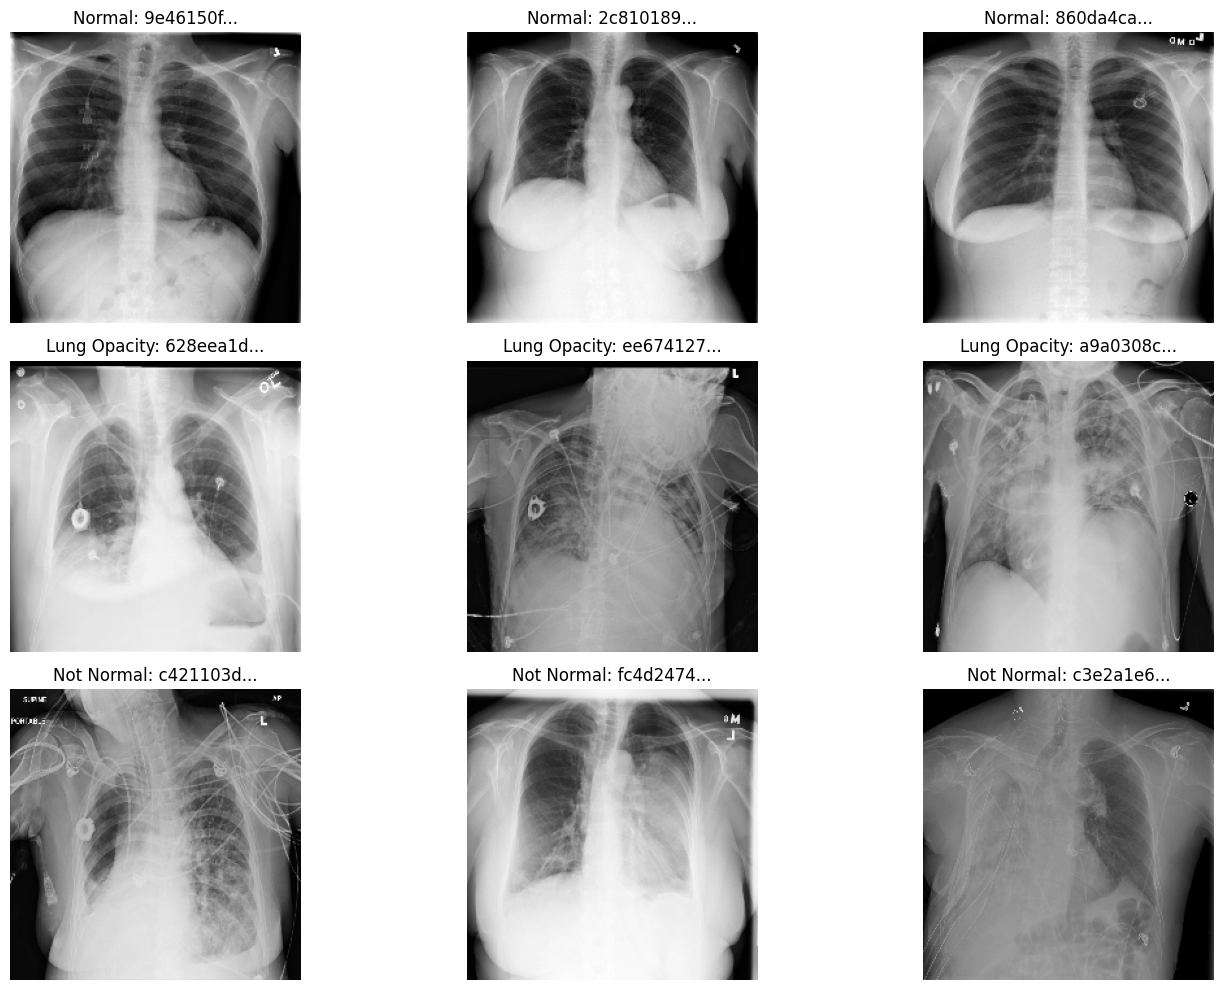

In [7]:
# Plot sample images from each class
plt.figure(figsize=(15, 10))

# Plot Normal images
for i, patient_id in enumerate(normal_patients):
    plt.subplot(3, 3, i+1)
    img = load_dicom_image(patient_id)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Normal: {patient_id[:8]}...")
    plt.axis('off')

# Plot Lung Opacity images
for i, patient_id in enumerate(opacity_patients):
    plt.subplot(3, 3, i+4)
    img = load_dicom_image(patient_id)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Lung Opacity: {patient_id[:8]}...")
    plt.axis('off')

# Plot Not Normal No Lung Opacity images
for i, patient_id in enumerate(not_normal_patients):
    plt.subplot(3, 3, i+7)
    img = load_dicom_image(patient_id)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Not Normal: {patient_id[:8]}...")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### **Step 5: Displaying images with bounding boxes**

In [8]:
# Function to load DICOM image with original size
def load_original_dicom(patient_id):
    """Load DICOM image without resizing"""
    zip_path = 'stage_2_train_images.zip'
    zip_archive = zipfile.ZipFile(zip_path, 'r')

    dicom_filename = f"stage_2_train_images/{patient_id}.dcm"

    if dicom_filename not in zip_archive.namelist():
        raise FileNotFoundError(f"{dicom_filename} not found in ZIP archive.")

    # Read file as bytes and load with pydicom
    with zip_archive.open(dicom_filename) as file:
        dicom_bytes = file.read()
        dicom = pydicom.dcmread(io.BytesIO(dicom_bytes))

    image = dicom.pixel_array
    image = image / np.max(image)
    if image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

In [9]:
# Function to draw bounding boxes on image
def draw_boxes(image, boxes):
    """Draw bounding boxes on the image"""

    # Ensure image is in uint8 format (0-255)
    if image.dtype != np.uint8:
        # Normalize to 0-255 and convert to uint8
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image = image.astype(np.uint8)

    # Convert grayscale image to RGB for colored boxes
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    for box in boxes:
        x, y = int(box['x']), int(box['y'])
        w, h = int(box['width']), int(box['height'])
        image_color = cv2.rectangle(image_color, (x, y), (x + w, y + h), (255, 0, 0), 2)

    return image_color

In [10]:
# Sample a few patients with Lung Opacity (which have bounding boxes)
opacity_patients = sample_patients_from_class('Lung Opacity')
opacity_with_boxes = [pid for pid in opacity_patients if pid in patient_boxes]

if not opacity_with_boxes:
    opacity_with_boxes = list(set(patient_boxes.keys()) &
                             set(patient_class_df[patient_class_df['class'] == 'Lung Opacity']['patientId']))[:4]


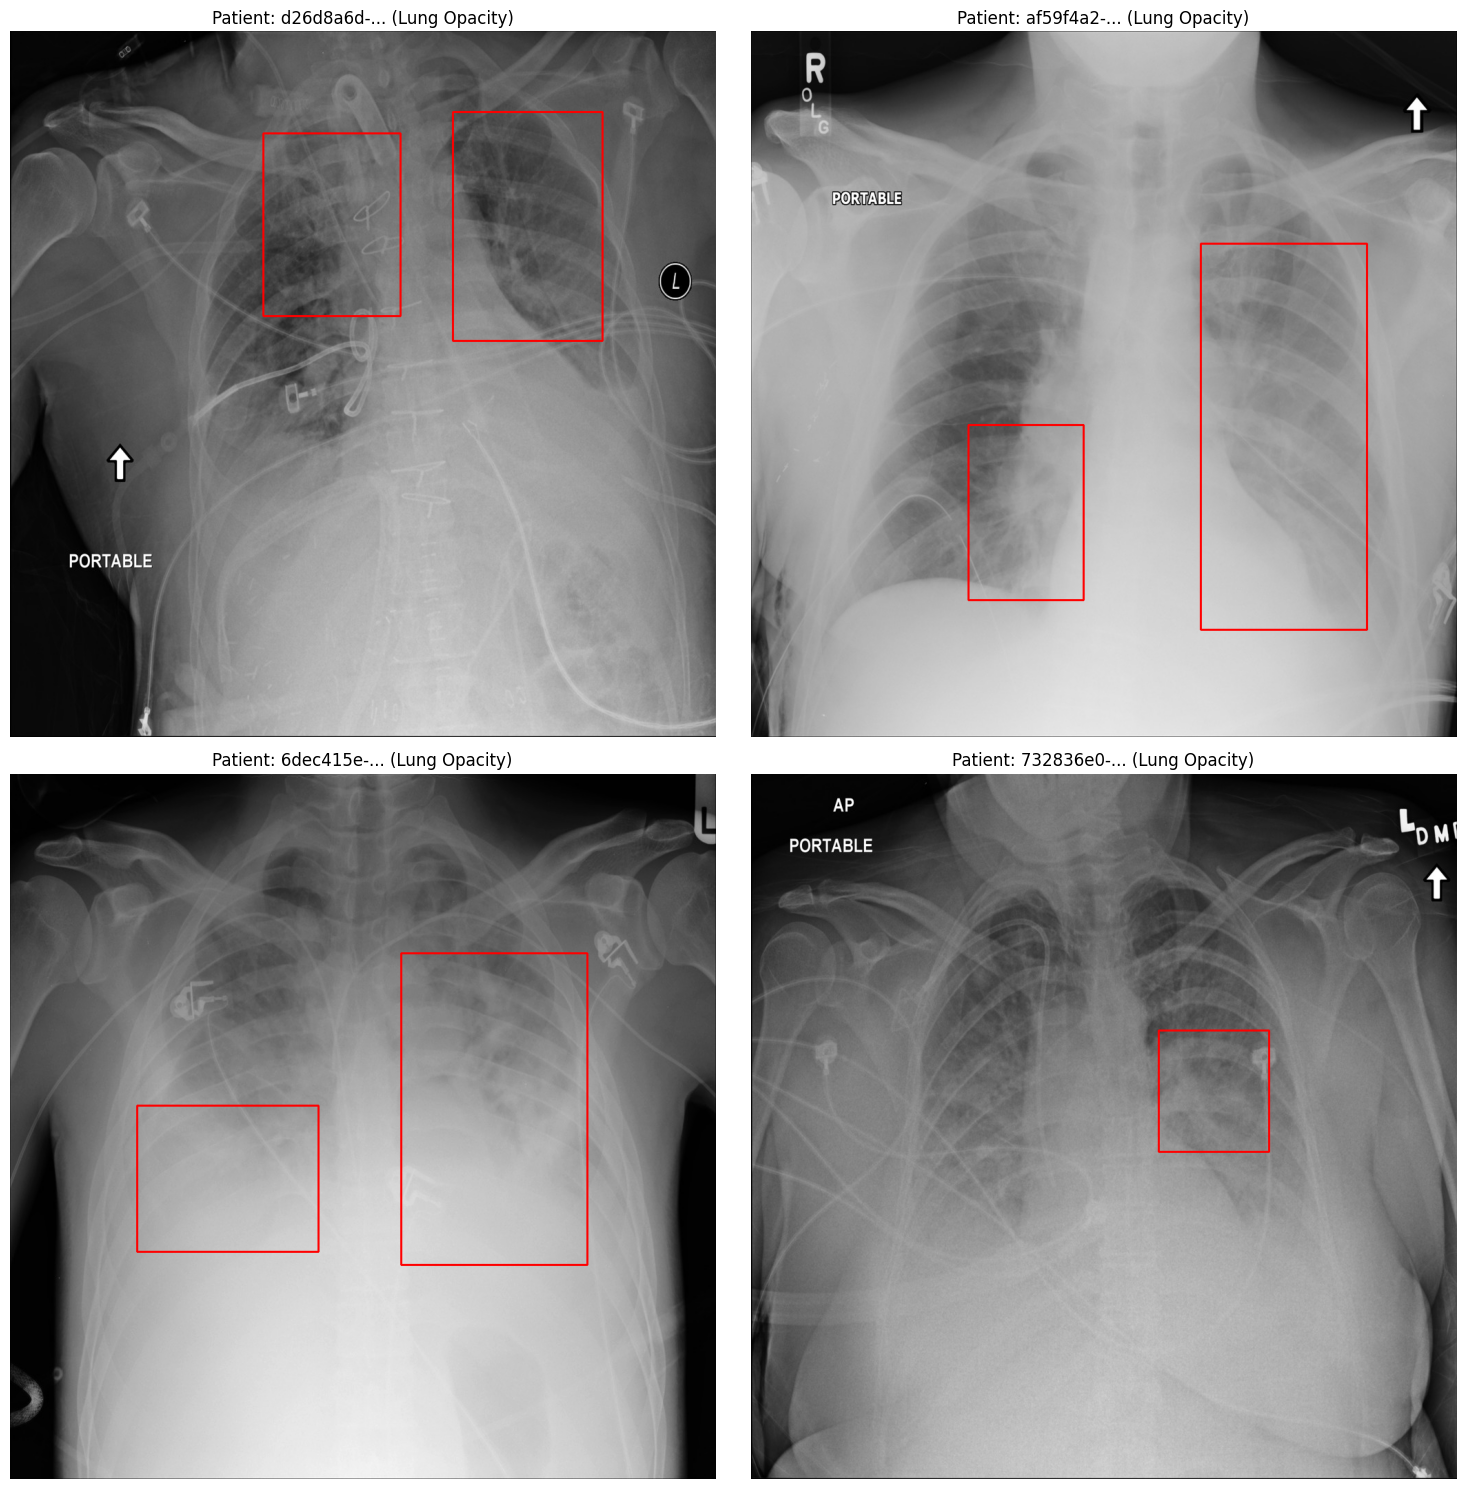

In [11]:
# Plot images with bounding boxes
plt.figure(figsize=(15, 15))

for i, patient_id in enumerate(opacity_with_boxes[:4]):
    try:
        plt.subplot(2, 2, i + 1)
        img = load_original_dicom(patient_id)

        if img is None:
            print(f"[Warning] Image for patient {patient_id} is None.")
            continue

        if patient_id in patient_boxes:
            img_with_boxes = draw_boxes(img, patient_boxes[patient_id])
            plt.imshow(img_with_boxes, cmap='gray')
        else:
            plt.imshow(img, cmap='gray')

        plt.title(f"Patient: {patient_id[:9]}... (Lung Opacity)")
        plt.axis('off')

    except Exception as e:
        print(f"[Error] Failed on patient {patient_id}: {e}")

plt.tight_layout()
plt.show()


#### **Step 6: Design, train and test basic CNN models for classification.**

In [12]:
# Create class mappings
class_mapping = {
    'Normal': 0,
    'Lung Opacity': 1,
    'No Lung Opacity / Not Normal': 2
}

reverse_class_mapping = {v: k for k, v in class_mapping.items()}

In [13]:
@lru_cache(maxsize=1000)
def decode_dicom_image_cached(patient_id, img_size=(224, 224)):
    """Cached version of DICOM image decoding for faster repeated access"""
    return decode_dicom_image(patient_id, img_size)

def decode_dicom_image(patient_id, img_size=(224, 224)):
    """Optimized DICOM image decoding with error handling"""
    zip_path = 'stage_2_train_images.zip'

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_archive:
            dicom_filename = f"stage_2_train_images/{patient_id}.dcm"

            if dicom_filename not in zip_archive.namelist():
                raise FileNotFoundError(f"{dicom_filename} not found in ZIP archive.")

            with zip_archive.open(dicom_filename) as file:
                dicom_bytes = file.read()
                dicom = pydicom.dcmread(io.BytesIO(dicom_bytes))

        # Optimized image processing
        image = dicom.pixel_array.astype(np.float32)

        # Robust normalization
        image_min, image_max = image.min(), image.max()
        if image_max > image_min:
            image = (image - image_min) / (image_max - image_min)
        else:
            image = np.zeros_like(image)

        # Convert to uint8 and resize efficiently
        image = (image * 255).astype(np.uint8)

        # Use PIL for efficient resizing
        pil_image = Image.fromarray(image)
        if pil_image.mode != 'RGB':
            pil_image = pil_image.convert('RGB')

        pil_image = pil_image.resize(img_size, Image.LANCZOS)
        image = np.array(pil_image, dtype=np.float32) / 255.0

        return image

    except Exception as e:
        print(f"Error processing {patient_id}: {e}")
        # Return a blank image in case of error
        return np.zeros((img_size[0], img_size[1], 3), dtype=np.float32)

In [14]:
def create_data_augmentation():
    def augment_fn(image):
        image = tf.cast(image, tf.float32)
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.9, 1.1)
        image = tf.image.random_saturation(image, 0.9, 1.1)
        return image

    return tf.keras.layers.Lambda(lambda x: augment_fn(x))


In [15]:
def prepare_optimized_dataset(patient_ids, labels, is_training=True,
                            img_size=Config.IMG_SIZE, batch_size=Config.BATCH_SIZE):
    """Optimized dataset preparation with better memory management"""

    def load_and_preprocess(patient_id, label):
        def _load(patient_id_tensor):
            pid = patient_id_tensor.numpy().decode('utf-8')
            try:
                img = decode_dicom_image(pid, img_size)
                return img.astype(np.float32)
            except Exception as e:
                print(f"Error loading {pid}: {e}")
                return np.zeros((img_size[0], img_size[1], 3), dtype=np.float32)

        image = tf.py_function(_load, [patient_id], tf.float32)
        image.set_shape((img_size[0], img_size[1], 3))
        image = tf.cast(image, tf.float32)
        label = tf.cast(label, tf.int32)

        return image, label

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((patient_ids, labels))

    # Optimize dataset pipeline
    dataset = dataset.map(
        load_and_preprocess,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=False
    )

    if is_training:
        # Apply caching before shuffling for better performance
        dataset = dataset.cache()
        dataset = dataset.shuffle(
            buffer_size=min(1000, len(patient_ids)),
            reshuffle_each_iteration=True
        )

        # Apply data augmentation
        augmentation = create_data_augmentation()
        dataset = dataset.map(
            lambda x, y: (augmentation(tf.cast(x, tf.float32), training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    else:
        dataset = dataset.cache()

    # Batch and prefetch
    dataset = dataset.batch(batch_size, drop_remainder=is_training)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [16]:
def create_efficient_cnn_model(input_shape=(224, 224, 3), num_classes=3):
    """Create an efficient CNN model using transfer learning"""

    # Use EfficientNetB0 as backbone
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze early layers, fine-tune later layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Add custom head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(Config.DROPOUT_RATE),
        layers.Dense(
            256,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(Config.L2_REG),
            kernel_initializer='he_normal'
        ),
        layers.BatchNormalization(),
        layers.Dropout(Config.DROPOUT_RATE / 2),
        layers.Dense(
            128,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(Config.L2_REG),
            kernel_initializer='he_normal'
        ),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Ensure float32 output
    ])

    return model

In [17]:
def create_custom_cnn_model(input_shape=(224, 224, 3), num_classes=3):
    """Custom CNN model architecture"""

    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.1),

        # Block 2
        layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.2),

        # Block 3
        layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.2),

        # Block 4
        layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),

        # Classifier
        layers.BatchNormalization(),
        layers.Dropout(Config.DROPOUT_RATE),
        layers.Dense(
            512,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(Config.L2_REG),
            kernel_initializer='he_normal'
        ),
        layers.BatchNormalization(),
        layers.Dropout(Config.DROPOUT_RATE),
        layers.Dense(
            256,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(Config.L2_REG),
            kernel_initializer='he_normal'
        ),
        layers.Dropout(Config.DROPOUT_RATE / 2),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    return model

In [18]:
def setup_callbacks(model_name='pneumonia_model_best'):
    """Setup optimized training callbacks"""
    return [
        callbacks.ModelCheckpoint(
            f'{model_name}.keras',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max',
            verbose=1,
            save_weights_only=False
        ),
        callbacks.EarlyStopping(
            patience=10,
            monitor='val_loss',
            restore_best_weights=True,
            verbose=1,
            min_delta=0.001
        ),
        callbacks.ReduceLROnPlateau(
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            monitor='val_loss',
            verbose=1,
            cooldown=2
        ),
        callbacks.CSVLogger(f'{model_name}_training_log.csv'),
        callbacks.TerminateOnNaN()
    ]

def calculate_class_weights(labels):
    """Calculate balanced class weights"""
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    return dict(zip(np.unique(labels), class_weights))

In [19]:
def main_training_pipeline(custom_model= False):
    """Main training pipeline with optimizations"""

    # Load and prepare data
    print("Loading patient data...")

    # Extract unique patients and their classes
    unique_patients = patient_class_df.drop_duplicates(subset=['patientId'])
    patient_ids = unique_patients['patientId'].values
    patient_classes = unique_patients['class'].map(class_mapping).astype(np.int64).values

    # Calculate class weights
    class_weight_dict = calculate_class_weights(patient_classes)
    print(f"Class weights: {class_weight_dict}")

    # Split data
    patient_ids_train, patient_ids_val, classes_train, classes_val = train_test_split(
        patient_ids, patient_classes,
        test_size=Config.VALIDATION_SPLIT,
        random_state=Config.SEED,
        stratify=patient_classes
    )

    print(f"Training set size: {len(patient_ids_train)}")
    print(f"Validation set size: {len(patient_ids_val)}")
    print(f"Class distribution in training set:")
    print(pd.Series(classes_train).map(reverse_class_mapping).value_counts())

    # Create optimized datasets
    print("Creating datasets...")
    train_dataset = prepare_optimized_dataset(
        patient_ids_train, classes_train, is_training=True
    )
    val_dataset = prepare_optimized_dataset(
        patient_ids_val, classes_val, is_training=False
    )

    # Create model
    print("Creating model...")
    if custom_model:
      model = create_custom_cnn_model() # Custom CNN 
    else:
      model = create_efficient_cnn_model()   # Use transfer learning

    # Compile with optimized settings
    model.compile(
        optimizer=optimizers.Adam(
            learning_rate=Config.LEARNING_RATE,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(model.summary())

    # Setup callbacks
    callback_list = setup_callbacks()

    # Train model
    print("Starting training...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=Config.EPOCHS,
        callbacks=callback_list,
        class_weight=class_weight_dict,
        verbose=1
    )

    # Clean up memory
    gc.collect()

    return model, history

In [20]:
# Memory optimization utilities
def clear_memory():
    """Clear memory and garbage collect"""
    gc.collect()
    tf.keras.backend.clear_session()

def get_memory_usage():
    """Get current memory usage"""
    import psutil
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024  # MB

In [ ]:
# Display data info
print(f"Class distribution:")
print(patient_class_df['class'].value_counts())
print()

# Run training pipeline
model, history = main_training_pipeline(True)

# Save final model
model.save('final_pneumonia_model.keras')
print("Training completed successfully!")

# Display training summary
print("Training Summary:")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")


Class distribution:
class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64

Loading patient data...
Class weights: {0: 1.004933529168079, 1: 1.4794854734974496, 2: 0.7524462115444266}
Training set size: 21347
Validation set size: 5337
Class distribution in training set:
No Lung Opacity / Not Normal    9457
Normal                          7081
Lung Opacity                    4809
Name: count, dtype: int64
Creating datasets...
Creating model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 128)    │             

 Total params: 1,442,851 (5.50 MB)

 Trainable params: 1,439,395 (5.49 MB)

 Non-trainable params: 3,456 (13.50 KB)

None
Starting training...
Epoch 1/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.4207 - loss: 1.5024 
Epoch 1: val_accuracy improved from -inf to 0.24171, saving model to pneumonia_model_best.keras
667/667 ━━━━━━━━━━━━━━━━━━━━ 10432s 15s/step - accuracy: 0.4207 - loss: 1.5023 - val_accuracy: 0.2417 - val_loss: 2.6316 - learning_rate: 1.0000e-04
Epoch 2/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4762 - loss: 1.2685
Epoch 2: val_accuracy improved from 0.24171 to 0.41559, saving model to pneumonia_model_best.keras
667/667 ━━━━━━━━━━━━━━━━━━━━ 3300s 5s/step - accuracy: 0.4762 - loss: 1.2684 - val_accuracy: 0.4156 - val_loss: 1.5430 - learning_rate: 1.0000e-04
Epoch 3/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5035 - loss: 1.1734
Epoch 3: val_accuracy did not improve from 0.41559
667/667 ━━━━━━━━━━━━━━━━━━━━ 3114s 5s/step - accuracy: 0.5035 - loss: 1.1734 - val_accuracy: 0.2556 - val_loss: 2.4958 - learning_rate: 1.0000e-04
Epoch 4/10
667/667 ━━━━━━━━━

In [21]:
# Run training pipeline
eff_model, eff_history = main_training_pipeline(False)

# Save final model
eff_model.save('final_pneumonia_custom_model.keras')
print("Training completed successfully!")

# Display training summary
print("Training Summary:")
print(f"Final training accuracy: {eff_history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {eff_history.history['val_accuracy'][-1]:.4f}")
print(f"Best validation accuracy: {max(eff_history.history['val_accuracy']):.4f}")

Loading patient data...
Class weights: {0: 1.004933529168079, 1: 1.4794854734974496, 2: 0.7524462115444266}
Training set size: 21347
Validation set size: 5337
Class distribution in training set:
No Lung Opacity / Not Normal    9457
Normal                          7081
Lung Opacity                    4809
Name: count, dtype: int64
Creating datasets...
Creating model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 253s 15us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,416,934 (16.85 MB)

 Trainable params: 1,715,251 (6.54 MB)

 Non-trainable params: 2,701,683 (10.31 MB)

None
Starting training...
Epoch 1/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3398 - loss: 1.4640
Epoch 1: val_accuracy improved from -inf to 0.22541, saving model to pneumonia_model_best.keras
667/667 ━━━━━━━━━━━━━━━━━━━━ 7636s 11s/step - accuracy: 0.3398 - loss: 1.4638 - val_accuracy: 0.2254 - val_loss: 1.2291 - learning_rate: 1.0000e-04
Epoch 2/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.3452 - loss: 1.2713
Epoch 2: val_accuracy improved from 0.22541 to 0.22559, saving model to pneumonia_model_best.keras
667/667 ━━━━━━━━━━━━━━━━━━━━ 482s 722ms/step - accuracy: 0.3452 - loss: 1.2713 - val_accuracy: 0.2256 - val_loss: 1.2758 - learning_rate: 1.0000e-04
Epoch 3/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.3548 - loss: 1.2318
Epoch 3: val_accuracy improved from 0.22559 to 0.44800, saving model to pneumonia_model_best.keras
667/667 ━━━━━━━━━━━━━━━━━━━━ 485s 727ms/step - accuracy: 0.3548 - loss: 1.2318 - val_accuracy: 0.4480 - val_loss: 1.1237 -

In [45]:
# Visualization functions
def plot_training_history(history):
    """Plot training history with accuracy and loss only"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(history.history['loss'], label='Training', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [46]:
def display_sample_predictions(model, dataset, class_names, num_samples=8):
    """Display sample predictions with images"""
    # Get a batch of data
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.ravel()
        
        for i in range(min(num_samples, len(images))):
            # Display image
            axes[i].imshow(images[i])
            axes[i].axis('off')
            
            # Get true and predicted labels
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[predicted_classes[i]]
            confidence = np.max(predictions[i]) * 100
            
            # Color based on correctness
            color = 'green' if true_label == pred_label else 'red'
            
            axes[i].set_title(
                f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
                color=color, fontweight='bold'
            )
        
        plt.tight_layout()
        plt.show()
        break

In [47]:
def evaluate_model(model, val_dataset, class_names):
    """Comprehensive model evaluation"""
    from sklearn.metrics import classification_report, confusion_matrix
    
    print("Evaluating model performance...")
    
    # Get predictions
    y_true = []
    y_pred = []
    
    for images, labels in val_dataset:
        predictions = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    
    # Classification report
    print("\n Classification Report:")
    print("=" * 50)
    report = classification_report(
        y_true, y_pred, 
        target_names=class_names,
        digits=4
    )
    print(report)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return y_true, y_pred

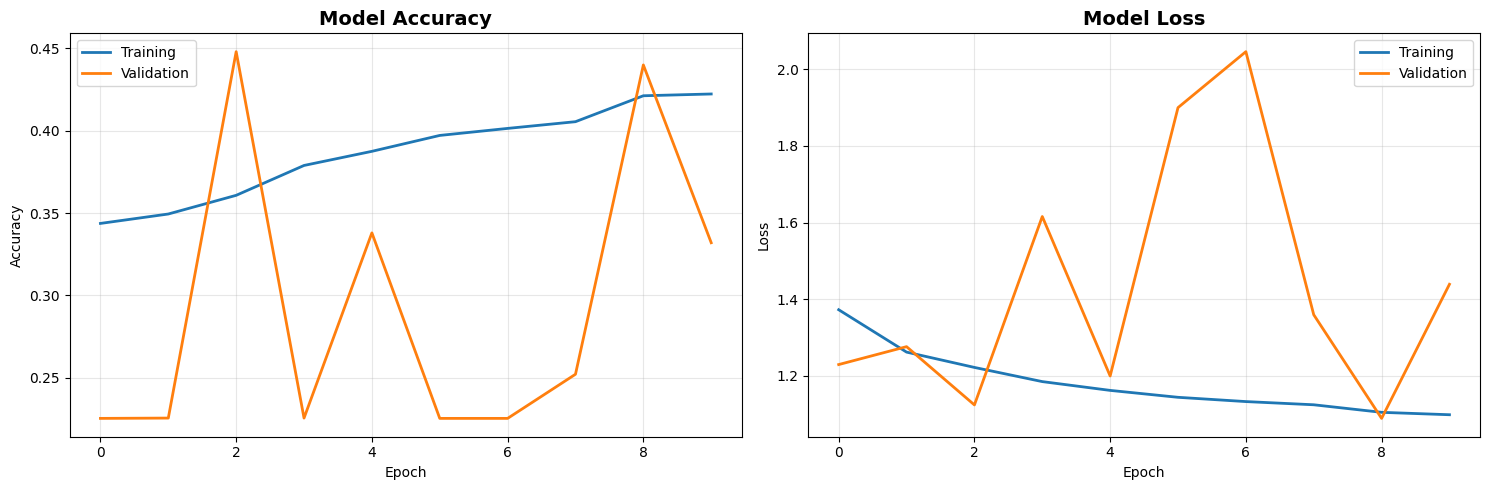

Evaluating model performance...

 Classification Report:
                              precision    recall  f1-score   support

                      Normal     0.4327    0.9441    0.5934      1770
                Lung Opacity     0.4590    0.5628    0.5056      1203
No Lung Opacity / Not Normal     0.0000    0.0000    0.0000      2364

                    accuracy                         0.4399      5337
                   macro avg     0.2972    0.5023    0.3663      5337
                weighted avg     0.2470    0.4399    0.3108      5337



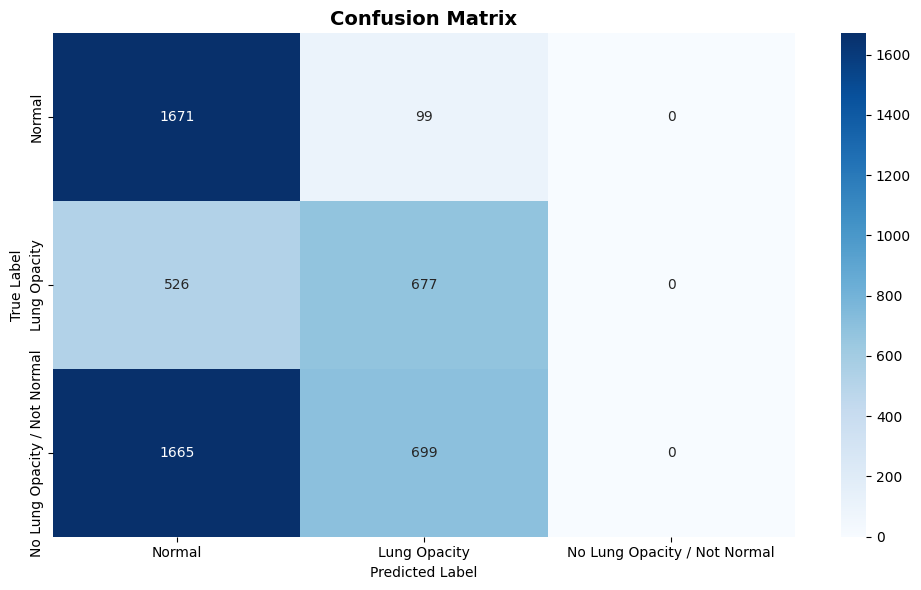

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


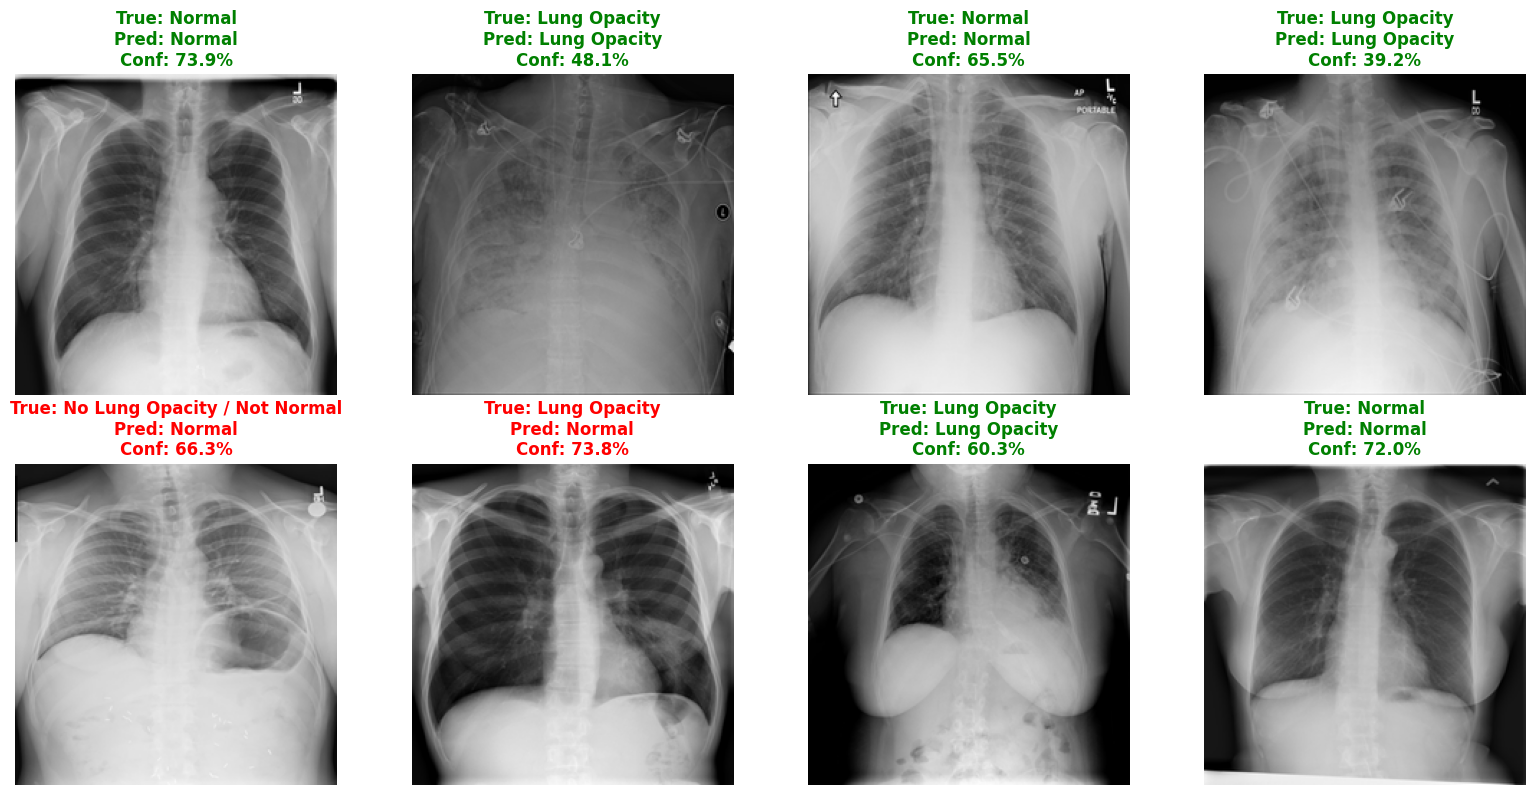

In [48]:
unique_patients = patient_class_df.drop_duplicates(subset=['patientId'])
patient_ids = unique_patients['patientId'].values
patient_classes = unique_patients['class'].map(class_mapping).astype(np.int64).values

# Split data
patient_ids_train, patient_ids_val, classes_train, classes_val = train_test_split(
    patient_ids, patient_classes,
    test_size=Config.VALIDATION_SPLIT,
    random_state=Config.SEED,
    stratify=patient_classes
)

val_dataset = prepare_optimized_dataset(
    patient_ids_val, classes_val, is_training=False
)

# After training, visualize results:
plot_training_history(eff_history)

# Evaluate model performance:
class_names = list(reverse_class_mapping.values())
y_true, y_pred = evaluate_model(eff_model, val_dataset, class_names)

# Display sample predictions:
display_sample_predictions(eff_model, val_dataset, class_names)